# Project Overview

A recommender system that recommends similar movies using textual data.

## Table of Content
1. [Exploratory Data Analysis](#eda)
2. [Data Preprocessing](#data_preprocessing)
3. [Machine Learning](#ml)
4. [Results](#results)

In [1]:
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation as punc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Importing files
credits_df = pd.read_csv("tmdb_5000_credits.csv")
movies_df = pd.read_csv("tmdb_5000_movies.csv")

<a id="eda"></a>
# Exploratory Data Analysis

In [3]:
# How is the data structured?
credits_df.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
movies_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [5]:
# Dataframe shape
movies_df_shape = movies_df.shape
credits_df_shape = credits_df.shape

print(f"Movie's file shape: {movies_df_shape}")
print(f"Credit's file shape: {credits_df_shape}")

Movie's file shape: (4803, 20)
Credit's file shape: (4803, 4)


In [6]:
# Data types of the movies file
movies_df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

In [7]:
# Data types of the credits file
credits_df.dtypes

movie_id     int64
title       object
cast        object
crew        object
dtype: object

In [8]:
# Check for any missing values
movies_df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                  31
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [9]:
# Credits file missing values
credits_df.isna().sum()

movie_id    0
title       0
cast        0
crew        0
dtype: int64

In [10]:
# Top 3 movies based on popularity
movies_df.sort_values(by='popularity', ascending=False).head(3)[["original_title"]]

,original_title
546,Minions
95,Interstellar
788,Deadpool


<a id="data_preprocessing"></a>
# Data Preprocessing

This section contains changes and manipulations made to the data.

In [11]:
# Fix missing overviews values
movies_df.loc[movies_df.original_title == 'The Dark Knight','overview'] = "When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice."
movies_df.loc[movies_df.original_title == 'Inside Out','overview'] = "After young Riley is uprooted from her Midwest life and moved to San Francisco, her emotions - Joy, Fear, Anger, Disgust and Sadness - conflict on how best to navigate a new city, house, and school."
movies_df.loc[movies_df.original_title == 'Guardians of the Galaxy','overview'] = "A group of intergalactic criminals must pull together to stop a fanatical warrior with plans to purge the universe."
movies_df.loc[movies_df.original_title == 'Interstellar','overview'] = "A team of explorers travel through a wormhole in space in an attempt to ensure humanity's survival."
movies_df.loc[movies_df.original_title == 'Inception','overview'] = "A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a C.E.O., but his tragic past may doom the project and his team to disaster."
movies_df.loc[movies_df.original_title == 'The Lord of the Rings: The Fellowship of the Ring','overview'] = "A meek Hobbit from the Shire and eight companions set out on a journey to destroy the powerful One Ring and save Middle-earth from the Dark Lord Sauron."
movies_df.loc[movies_df.original_title == 'Django Unchained','overview'] = "With the help of a German bounty-hunter, a freed slave sets out to rescue his wife from a brutal plantation owner in Mississippi."
movies_df.loc[movies_df.original_title == 'The Wolf of Wall Street','overview'] = "Based on the true story of Jordan Belfort, from his rise to a wealthy stock-broker living the high life to his fall involving crime, corruption and the federal government."
movies_df.loc[movies_df.original_title == 'The Lord of the Rings: The Return of the King','overview'] = "Gandalf and Aragorn lead the World of Men against Sauron's army to draw his gaze from Frodo and Sam as they approach Mount Doom with the One Ring."
movies_df.loc[movies_df.original_title == 'The Lord of the Rings: The Two Towers','overview'] = "While Frodo and Sam edge closer to Mordor with the help of the shifty Gollum, the divided fellowship makes a stand against Sauron's new ally, Saruman, and his hordes of Isengard."
movies_df.loc[movies_df.original_title == 'The Lion King','overview'] = "After the murder of his father, a young lion prince flees his kingdom only to learn the true meaning of responsibility and bravery."
movies_df.loc[movies_df.original_title == 'The Matrix','overview'] = "When a beautiful stranger leads computer hacker Neo to a forbidding underworld, he discovers the shocking truth--the life he knows is the elaborate deception of an evil cyber-intelligence."
movies_df.loc[movies_df.original_title == 'Fight Club','overview'] = "An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more."
movies_df.loc[movies_df.original_title == 'The Green Mile','overview'] = "The lives of guards on Death Row are affected by one of their charges: a black man accused of child murder and rape, yet who has a mysterious gift."
movies_df.loc[movies_df.original_title == 'Forrest Gump','overview'] = "The presidencies of Kennedy and Johnson, the Vietnam War, the Watergate scandal and other historical events unfold from the perspective of an Alabama man with an IQ of 75, whose only desire is to be reunited with his childhood sweetheart"
movies_df.loc[movies_df.original_title == 'Se7en','overview'] = "Two detectives, a rookie and a veteran, hunt a serial killer who uses the seven deadly sins as his motives."
movies_df.loc[movies_df.original_title == "Schindler's List",'overview'] = "In German-occupied Poland during World War II, industrialist Oskar Schindler gradually becomes concerned for his Jewish workforce after witnessing their persecution by the Nazis."
movies_df.loc[movies_df.original_title == 'The Shawshank Redemption','overview'] = "Over the course of several years, two convicts form a friendship, seeking consolation and, eventually, redemption through basic compassion."
movies_df.loc[movies_df.original_title == 'The Empire Strikes Back','overview'] = "After the Rebels are overpowered by the Empire, Luke Skywalker begins Jedi training with Yoda, while his friends are pursued across the galaxy by Darth Vader and bounty hunter Boba Fett."
movies_df.loc[movies_df.original_title == 'The Silence of the Lambs','overview'] = "A young F.B.I. cadet must receive the help of an incarcerated and manipulative cannibal killer to help catch another serial killer, a madman who skins his victims."
movies_df.loc[movies_df.original_title == 'Back to the Future','overview'] = "Marty McFly, a 17-year-old high school student, is accidentally sent 30 years into the past in a time-traveling DeLorean invented by his close friend, the maverick scientist Doc Brown."
movies_df.loc[movies_df.original_title == '千と千尋の神隠し','overview'] = "During her family's move to the suburbs, a sullen 10-year-old girl wanders into a world ruled by gods, witches, and spirits, and where humans are changed into beasts."
movies_df.loc[movies_df.original_title == 'The Imitation Game','overview'] = "During World War II, the English mathematical genius Alan Turing tries to crack the German Enigma code with help from fellow mathematicians while attempting to come to terms with his troubled private life."
movies_df.loc[movies_df.original_title == 'Chiamatemi Francesco - Il Papa della gente','overview'] = "The story of Pope Francis' life."
movies_df.loc[movies_df.original_title == 'The Godfather: Part II','overview'] = "The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate."
movies_df.loc[movies_df.original_title == 'Star Wars','overview'] = "Luke Skywalker joins forces with a Jedi Knight, a cocky pilot, a Wookiee and two droids to save the galaxy from the Empire's world-destroying battle station, while also attempting to rescue Princess Leia from the mysterious Darth Vader."
movies_df.loc[movies_df.original_title == 'Pulp Fiction','overview'] = "The lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption."
movies_df.loc[movies_df.original_title == 'The Godfather','overview'] = "The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son."
movies_df.loc[movies_df.original_title == 'Whiplash','overview'] = "A promising young drummer enrolls at a cut-throat music conservatory where his dreams of greatness are mentored by an instructor who will stop at nothing to realize a student's potential."
movies_df.loc[movies_df.original_title == 'To Be Frank, Sinatra at 100','overview'] = "The life of Frank Sinatra, as an actor and singer and the steps along the way that led him to become such an icon."
movies_df.loc[movies_df.original_title == 'Food Chains','overview'] = "There is so much interest in food these days yet there is almost no interest in the hands that pick that food. In the US, farm labor has always been one of the most difficult and poorly paid jobs and has relied on some of the nation's most vulnerable people. While the legal restrictions which kept people bound to farms, like slavery, have been abolished, exploitation still exists, ranging from wage theft to modern-day slavery. These days, this exploitation is perpetuated by the corporations at the top of the food chain: supermarkets. Their buying power has kept wages pitifully low and has created a scenario where desperately poor people are willing to put up with anything to keep their jobs."

In [12]:
# Filtering to only English movies
movies_df = movies_df.loc[movies_df.original_language=='en']

# Dataset now contains only movies that are English
movies_df.original_language.value_counts()

original_language
en    4505
Name: count, dtype: int64

Create a threshold to subset for only popular movies.

**Note**: This adds bias

In [13]:
# Statistical data before filtering popularity column
movies_df.popularity.describe()

count    4505.000000
mean       22.177435
std        32.512782
min         0.000000
25%         5.000500
50%        13.668633
75%        29.253833
max       875.581305
Name: popularity, dtype: float64

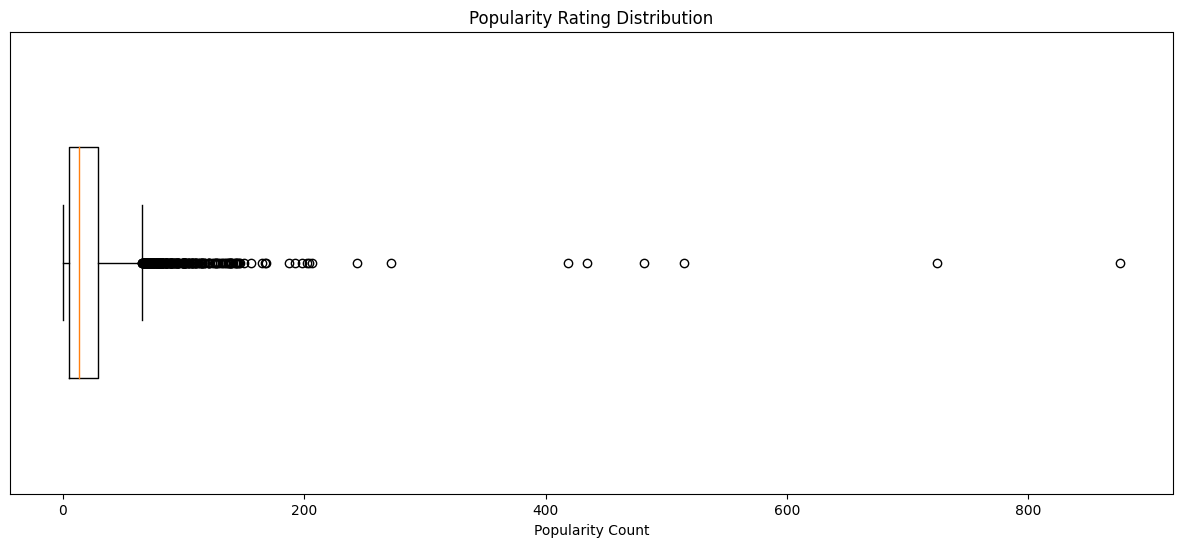

In [14]:
# Box plot of the distribution before filtering
plt.figure(figsize=(15,6))
plt.boxplot(movies_df.popularity, vert=False, widths=.5)
plt.title("Popularity Rating Distribution")
plt.xlabel("Popularity Count")
plt.yticks(ticks=[])
plt.show()

In [15]:
# Filter vote counts above the 25th quartile
movies_df.vote_count.describe()

count     4505.000000
mean       719.023751
std       1263.358181
min          0.000000
25%         58.000000
50%        251.000000
75%        788.000000
max      13752.000000
Name: vote_count, dtype: float64

In [16]:
# Filter vote average above the 50th quartile
movies_df.vote_average.describe()

count    4505.000000
mean        6.065683
std         1.185188
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

In [17]:
# Movies needed based on project requirements
req_movies = ["The Dark Knight Rises", "Batman Begins", "Batman Returns", "Batman", "Batman Forever", "Prison", "Penitentiary", "1982",\
"Flying By", "Buffalo '66", "Aladdin", "Spirit: Stallion of the Cimarron", "Pocahontas", "The Legend of Hercules", "The Book of Life"]

# Filter the data
movies_df = movies_df.loc[(movies_df.popularity.quantile(.75)<movies_df.popularity) & (movies_df["vote_average"].quantile(.5)<movies_df["vote_average"])\
& (movies_df["vote_count"].quantile(.25)<movies_df["vote_count"]) | (movies_df['original_title'].isin(req_movies))]

# The dataset now is 790 rows besides 4803
movies_df.shape

(790, 20)

In [18]:
# Returns a list of the data attributes we need
def data_cleaner(data):
    parsed = []
    for i in ast.literal_eval(data):
        parsed.append(i['name'])
    return parsed

# Create a new dataframe with the transformed data
movies_df_transformed = pd.DataFrame()

movies_df_transformed['id'] = movies_df['id']
movies_df_transformed['genres'] = movies_df['genres'].apply(data_cleaner)
movies_df_transformed['keywords'] = movies_df['keywords'].apply(data_cleaner)
movies_df_transformed['production_company'] = movies_df['production_companies'].apply(data_cleaner)
movies_df_transformed['title'] = movies_df['original_title']
movies_df_transformed['overview'] = movies_df['overview']
movies_df_transformed['tagline'] = movies_df['tagline']
movies_df_transformed['popularity'] = movies_df['popularity']

movies_df_transformed.head(2)

,id,genres,keywords,production_company,title,overview,tagline,popularity
0,19995,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...",Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,150.437577
1,285,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.",139.082615


In [19]:
# Find cast members
def cast_finder(lis):
    parsed = []
    for i in ast.literal_eval(lis):
        if i['character'] != "Additional Voices (voice)":
            parsed.append(i['character'])
        parsed.append(i['name'])
    return parsed

# Find crew members
def crew_finder(lis):
    parsed = []
    for i in ast.literal_eval(lis):
        if (
            i['job'] == "Director" or i['job'] == "Producer" or i['job'] == "Writer" or
            i['job'] == "Editor" or i['job'] == "Visual Effects Producer" or i['job'] == "Executive Producer" or i['job'] == "Story" or
            i['job'] == "Production Manager" or i['job'] == "Screenplay" or i['job'] == "Visual Effects"
            ):
            parsed.append(i['name'])
    return parsed


# Cast column
credits_df['cast'] = credits_df['cast'].apply(cast_finder)

# Crew members
credits_df['crew'] = credits_df['crew'].apply(crew_finder)

In [20]:
credits_df.drop(columns=['title'], inplace=True)

# Creating a training dataframe
merged_df = movies_df_transformed.merge(credits_df, left_on='id', right_on='movie_id', how='left')

# Droping the extra id
merged_df.drop(columns='movie_id', inplace=True)

merged_df.head(2)

,id,genres,keywords,production_company,title,overview,tagline,popularity,cast,crew
0,19995,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...",Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,150.437577,"[Jake Sully, Sam Worthington, Neytiri, Zoe Sal...","[Stephen E. Rivkin, James Cameron, James Camer..."
1,285,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.",139.082615,"[Captain Jack Sparrow, Johnny Depp, Will Turne...","[Gore Verbinski, Jerry Bruckheimer, Ted Elliot..."


<a id="ml"></a>
# Machine Learning

- Remove stop words
- Porter Stemmer (NLTK)
- TFIDF-Vectorizer (Scikit-Learn)
- Cosine Similarities (Scikit-Learn)

In [21]:
# Loops through a column and removes stop words and lowers text
def column_unpacker(lis):
    parsed = " ".join([word.lower() for word in lis if word not in stopwords.words('english')])
    return parsed

# Cleans the cast and crew names
def cast_crew(name):
    new_name = " ".join(["".join(letter.lower().replace(" ", '') for letter in word if letter not in punc) for word in name])
    return new_name

# Store text data
textual_df = pd.DataFrame()

textual_df['id'] = merged_df['id']
textual_df['title'] = merged_df['title']
textual_df['overview'] = merged_df['overview']
textual_df['tagline'] = merged_df['tagline']
textual_df['genres'] = merged_df['genres'].apply(lambda x: column_unpacker(x))
textual_df['keywords'] = merged_df['keywords'].apply(lambda x: column_unpacker(x))
textual_df['cast'] = merged_df['cast'].apply(lambda x: cast_crew(x))
textual_df['crew'] = merged_df['crew'].apply(lambda x: cast_crew(x))
textual_df['production_companies'] = merged_df['production_company'].apply(lambda x: cast_crew(x))

# The data we will use for ML
textual_df.head(3)

,id,title,overview,tagline,genres,keywords,cast,crew,production_companies
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,action adventure fantasy science fiction,culture clash future space war space colony so...,jakesully samworthington neytiri zoesaldana dr...,stephenerivkin jamescameron jamescameron james...,ingeniousfilmpartners twentiethcenturyfoxfilmc...
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.",adventure fantasy action,ocean drug abuse exotic island east india trad...,captainjacksparrow johnnydepp willturner orlan...,goreverbinski jerrybruckheimer tedelliott terr...,waltdisneypictures jerrybruckheimerfilms secon...
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,A Plan No One Escapes,action adventure crime,spy based on novel secret agent sequel mi6 bri...,jamesbond danielcraig blofeld christophwaltz m...,sammendes johnlogan johnlogan leesmith barbara...,columbiapictures danjaq b24


In [22]:
pd.options.mode.chained_assignment = None

# Initialzie the Potter Stemmer
porter_stemmer = PorterStemmer()

# Replace missing taglines
textual_df['tagline'].loc[textual_df['tagline'].isna()] = ''

# Stemming and cleaning process for text data
def text_cleaner(text, stemmer):
    tokens = re.split(r'\W+', text)
    clean = " ".join([stemmer.stem(word).lower() for word in tokens\
                        if word not in stopwords.words('english') and\
                        word not in punc])
    return clean

# Calling the text cleaner
textual_df['overview_cleaned'] = textual_df['overview'].apply(lambda x: text_cleaner(x, stemmer=porter_stemmer))
textual_df['tagline_cleaned'] = textual_df['tagline'].apply(lambda x: text_cleaner(x, stemmer=porter_stemmer))

# Dataframe for the ML algo
ml_df = textual_df[['title','cast', 'crew', 'overview_cleaned', 'tagline_cleaned', 'genres', 'keywords', 'production_companies']]
ml_df['combined'] = textual_df['cast']+" "+textual_df['crew']+" "+textual_df['overview_cleaned']+" "+textual_df['tagline_cleaned']+" "\
                    +textual_df['genres']+" "+textual_df['keywords']+" "+textual_df['production_companies']
ml_df.head(3)

,title,cast,crew,overview_cleaned,tagline_cleaned,genres,keywords,production_companies,combined
0,Avatar,jakesully samworthington neytiri zoesaldana dr...,stephenerivkin jamescameron jamescameron james...,in 22nd centuri parapleg marin dispatch moon p...,enter world pandora,action adventure fantasy science fiction,culture clash future space war space colony so...,ingeniousfilmpartners twentiethcenturyfoxfilmc...,jakesully samworthington neytiri zoesaldana dr...
1,Pirates of the Caribbean: At World's End,captainjacksparrow johnnydepp willturner orlan...,goreverbinski jerrybruckheimer tedelliott terr...,captain barbossa long believ dead come back li...,at end world adventur begin,adventure fantasy action,ocean drug abuse exotic island east india trad...,waltdisneypictures jerrybruckheimerfilms secon...,captainjacksparrow johnnydepp willturner orlan...
2,Spectre,jamesbond danielcraig blofeld christophwaltz m...,sammendes johnlogan johnlogan leesmith barbara...,a cryptic messag bond past send trail uncov si...,a plan no one escap,action adventure crime,spy based on novel secret agent sequel mi6 bri...,columbiapictures danjaq b24,jamesbond danielcraig blofeld christophwaltz m...


In [23]:
tfidf = TfidfVectorizer()

# Fitting into seperate TFIDFs
tfidf_matrix = tfidf.fit_transform(ml_df['combined'])

cosine = cosine_similarity(tfidf_matrix)

# Function to look up the movie
def get_movie_recommendation(lookup):
    print (f"Recommendations for {lookup}: \n")
    for index, name in enumerate(cosine):
        if ml_df.title.loc[index] == lookup:
            [print (ml_df.title.loc[i]) for i in name.argsort()[:-7:-1][1:]]

<a id="results"></a>
# Results

In [24]:
get_movie_recommendation("The Dark Knight")

Recommendations for The Dark Knight: 

Batman Returns
The Dark Knight Rises
Batman
Batman Begins
Man of Steel


In [25]:
get_movie_recommendation("The Shawshank Redemption")

Recommendations for The Shawshank Redemption: 

The Green Mile
Prison
Penitentiary
Escape Plan
The Mist


In [26]:
get_movie_recommendation("Frozen")

Recommendations for Frozen: 

Wreck-It Ralph
The Princess and the Frog
Pocahontas
Brave
Snow White and the Seven Dwarfs


## Credits
- [Kazi Shahria](https://www.linkedin.com/in/kazishahria/)
- [Maham Rasheda](https://www.linkedin.com/in/mahamrasheda/)
- [Muhammad Elbadri](https://www.linkedin.com/in/muhammadelbadri/)
- [Sumaiya Gulshan](https://www.linkedin.com/in/sumaiya-gulshan-285289232/)